Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.


*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [275]:
from functools import partial

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.utils import resample

In [202]:
X, y = datasets.load_digits(n_class=10, return_X_y=True, as_frame=False)

display(X)
display(y)

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

array([0, 1, 2, ..., 8, 9, 8])

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [203]:
def draw_dig(images, labels):
    _, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 5))
    for ax, image, label in zip(axes.flatten(), images, labels):
        ax.set_axis_off()
        ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)
        ax.set_title(label)

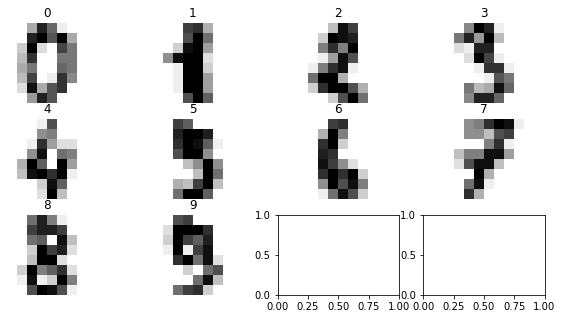

In [204]:
draw_dig(X[:10], y[:10])


# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [205]:
# KMeans

k_mean_model = KMeans(n_clusters=10, random_state=15, n_init=100)
k_mean_model.fit(X)

k_mean_model.labels_
# k_mean_model.cluster_centers_

array([1, 6, 6, ..., 6, 5, 5])

In [206]:
# AgglomerativeClustering

agg_model = AgglomerativeClustering(n_clusters=10,)
agg_model.fit(X)
agg_model.labels_
agg_model

AgglomerativeClustering(n_clusters=10)

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [207]:
def cluster_centers(XX, labels):
    df = pd.DataFrame(XX)
    df['label'] = labels
    return df.groupby('label').mean().values

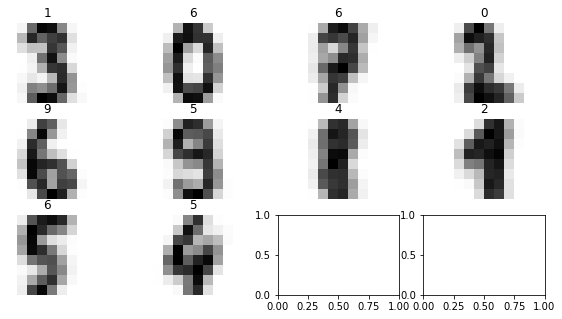

In [208]:
# KMeans
centers = cluster_centers(X, k_mean_model.labels_)
draw_dig(centers, k_mean_model.labels_)
# draw_dig(k_mean_model.cluster_centers_, k_mean_model.labels_)


распозналось более-менее. проблемы с цифрами 1, 2, 7, 8 

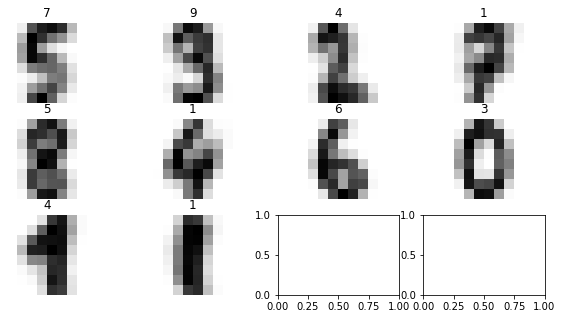

In [209]:
# AgglomerativeClustering

centers = cluster_centers(X, agg_model.labels_)
draw_dig(centers, agg_model.labels_)


проблемы с цифрами 9 (или 3)

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

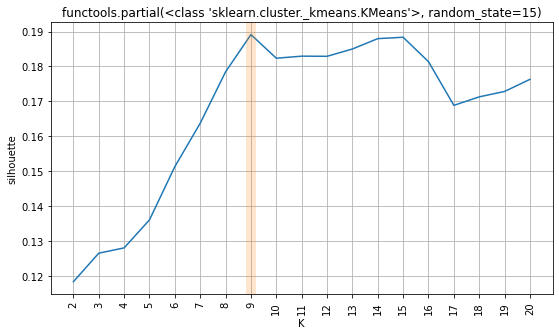

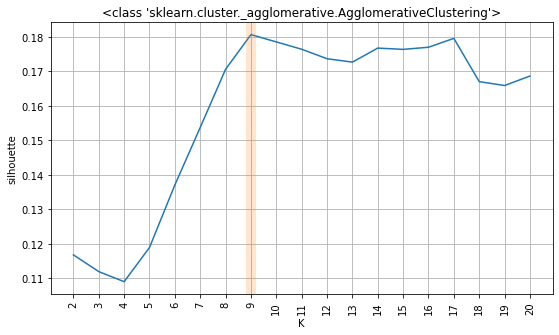

In [210]:
# silhouette

from functools import partial


k_model = partial(KMeans, random_state=15)
a_model = AgglomerativeClustering

K = 20
for model_cls in (k_model, a_model):
    silhouettes = []
    rng = range(2, K+1)
    for k in rng:
        model = model_cls(n_clusters=k)
        model.fit(X)
        sil = silhouette_score(X, model.labels_)
        silhouettes.append(sil)
        
    plt.figure(figsize=(9, 5))
    plt.plot(rng, silhouettes, label='silhouettes')
    plt.axvline(rng[np.argmax(silhouettes)], color='C1', lw=10, alpha=0.2)
    plt.title(model_cls)
    plt.xlabel('K')
    plt.ylabel('silhouette')
    plt.grid(True)
    plt.xticks(rng, rotation='vertical')
    plt.show()
        

**Вывод:** максимальный силуэт достигается при **K=9**, что явно не то, что мы ожидали

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [211]:
# V-measure

measures_params = {'homogeneity': 0, 'completeness': 1, 'v_measure': 2, 'silhouette': 3}

k_model = ('KMeans', partial(KMeans, random_state=15, n_init=50))
a_model = ('AgglomerativeClustering', AgglomerativeClustering)

K = 20
rng = range(2, K+1)
model_measures = {}
for model_name, model_cls in (k_model, a_model):
    print(f'model_name = {model_name}')
    measures = []    
    for k in rng:
        model = model_cls(n_clusters=k)
        model.fit(X)
        silhouette = silhouette_score(X, model.labels_)
        homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, model.labels_)
        measures.append((homogeneity, completeness, v_measure, silhouette))
        model_measures[model_name] = measures
        print(f'k={k} v_measure={v_measure}, silhouette={silhouette}')
        

model_name = KMeans
k=2 v_measure=0.36001205373704537, silhouette=0.11832841100655983
k=3 v_measure=0.4041226970761304, silhouette=0.12649602374037858
k=4 v_measure=0.4574956869773907, silhouette=0.12853647041175942
k=5 v_measure=0.5794170872184342, silhouette=0.1378892361397985
k=6 v_measure=0.5978771683365801, silhouette=0.15112919446310868
k=7 v_measure=0.657181829965452, silhouette=0.1635439949476128
k=8 v_measure=0.7149896573661967, silhouette=0.1788550507773221
k=9 v_measure=0.721919712393972, silhouette=0.18925320253793754
k=10 v_measure=0.7433591627013836, silhouette=0.1824603259513644
k=11 v_measure=0.776193801104502, silhouette=0.18321819695558977
k=12 v_measure=0.7714234149797499, silhouette=0.1830240929809272
k=13 v_measure=0.7747188226820909, silhouette=0.18555129296442485
k=14 v_measure=0.7791877914499247, silhouette=0.1879682810765437
k=15 v_measure=0.7867786134629404, silhouette=0.1870362042754034
k=16 v_measure=0.7792201856650723, silhouette=0.17416568505988833
k=17 v_

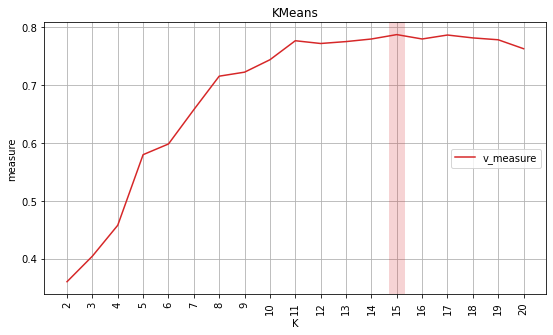

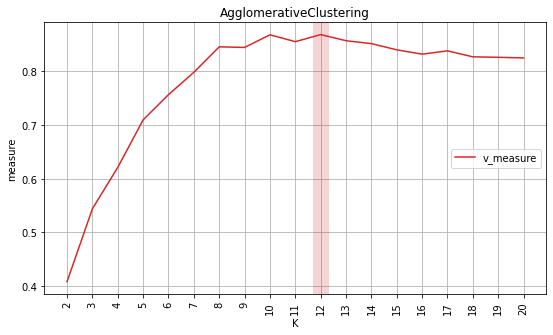

In [212]:
# out_params = ('homogeneity', 'completeness', 'v_measure', 'silhouette')
out_params = ('v_measure',)


for model_name, model_meas in model_measures.items():
    m_meas = np.array(model_meas) 
                    
    plt.figure(figsize=(9, 5))
    plt.title(model_name)
    plt.xlabel('K')
    plt.ylabel('measure')
    plt.grid(True)
    plt.xticks(rng, rotation='vertical')       
    for param in out_params:
        i = measures_params[param]
        meas = m_meas[:, i]
        color=f'C{i+1}'
        plt.plot(rng, meas, color=color, label=param)
        plt.axvline(rng[np.argmax(meas)], color=color, lw=10+i*3, alpha=0.2)
        
    plt.legend(loc='center right')        
    plt.show()    
    

**Вывод:** максимальая 𝑉-мера для KMeans достигается на K=15, для AgglomerativeClustering на K=12

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [213]:
# TruncatedSVD

measures_params = {'homogeneity': 0, 'completeness': 1, 'v_measure': 2, 'silhouette': 3}

n_clusters = 10 
k_model = ('KMeans', partial(KMeans, n_clusters=n_clusters, random_state=15, n_init=50))
a_model = ('AgglomerativeClustering', partial(AgglomerativeClustering, n_clusters=n_clusters))

сomponents_nums = [2, 5, 10, 20]
model_measures_tr = {}
for model_name, model_cls in (k_model, a_model):
    measures = []
    model = model_cls()
    for c_num  in сomponents_nums:
        trunc = TruncatedSVD(n_components=c_num, n_iter=7, random_state=42)      
        XX = trunc.fit_transform(X)
        
        model.fit(XX)
        silhouette = silhouette_score(XX, model.labels_)
        homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, model.labels_)
        measures.append((homogeneity, completeness, v_measure, silhouette))
        model_measures_tr[model_name] = measures
        print(f'k={c_num} meas={v_measure} sil={silhouette}')
           
           

k=2 meas=0.34714890137453625 sil=0.3488600633667945
k=5 meas=0.6349670267154036 sil=0.31217706045095006
k=10 meas=0.7215689584759067 sil=0.26322638023865397
k=20 meas=0.7406391563296724 sil=0.21257090369670995
k=2 meas=0.3337189903948925 sil=0.280816984702686
k=5 meas=0.6756036446423491 sil=0.2727411886319517
k=10 meas=0.8259753348813222 sil=0.25071325328037264
k=20 meas=0.8171311050922185 sil=0.19566180422962248


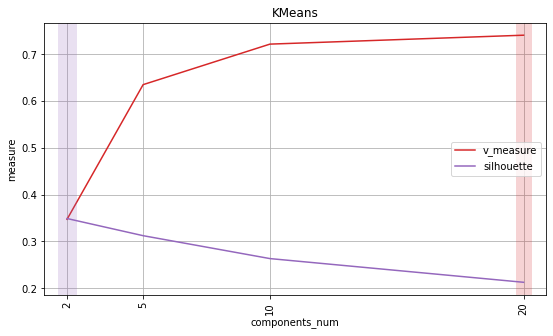

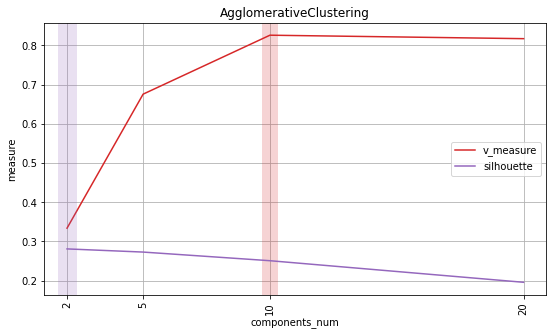

In [214]:
out_params = ('v_measure', 'silhouette')


for model_name, model_meas in model_measures_tr.items():
    m_meas = np.array(model_meas) 
                    
    plt.figure(figsize=(9, 5))
    plt.title(model_name)
    plt.xlabel('сomponents_num')
    plt.ylabel('measure')
    plt.grid(True)
    plt.xticks(сomponents_nums, rotation='vertical')       
    for param in out_params:
        i = measures_params[param]
        meas = m_meas[:, i]
        color=f'C{i+1}'
        plt.plot(сomponents_nums, meas, color=color, label=param)
        plt.axvline(сomponents_nums[np.argmax(meas)], color=color, lw=10+i*3, alpha=0.2)
        
    plt.legend(loc='center right')        
    plt.show()   
    

**Выводы:** максимальный силуэт для обоих случаев достагается при n_components=2, 𝑉-мера максимальна для KMeans при n_components=20, для AgglomerativeClustering при n_components=10

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

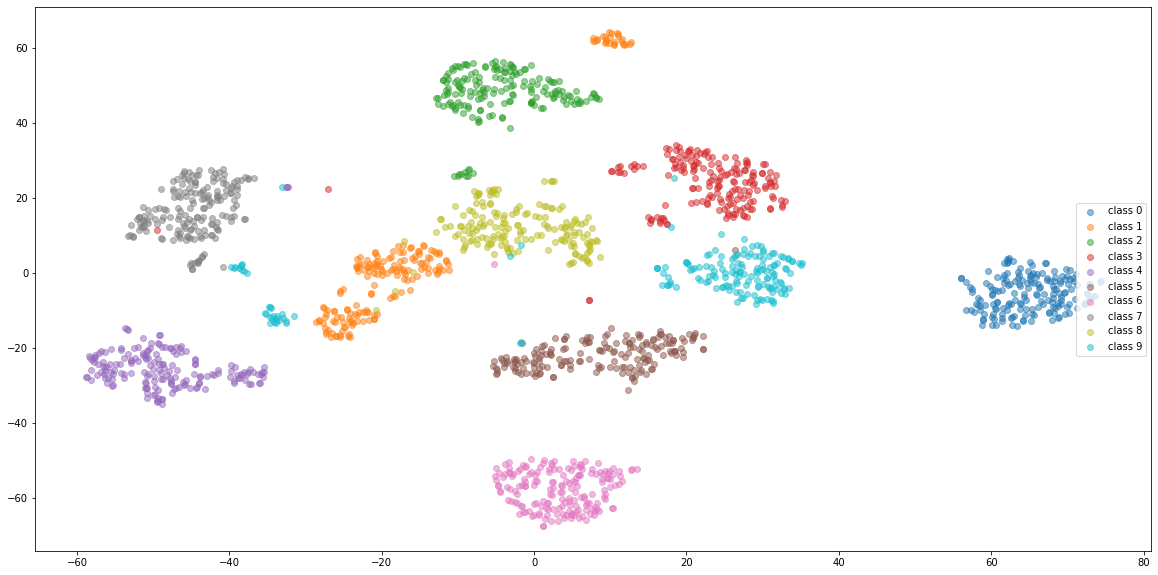

In [215]:
n_clusters = 10
n_components = 2
trunc = TSNE(n_components=n_components, random_state=42)      
X_trunc = trunc.fit_transform(X)

plt.figure(figsize=(20, 10))
for nc in range(0, n_clusters):
    plt.scatter(X_trunc[y == nc, 0], X_trunc[y == nc, 1], 
                color=f'C{nc}', label=f'class {nc}', alpha=0.5)

plt.legend(loc='center right')  
plt.show()

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [216]:
n_clusters = 10 
k_model = ('KMeans', partial(KMeans, n_clusters=n_clusters, random_state=15, n_init=50))
a_model = ('AgglomerativeClustering', partial(AgglomerativeClustering, n_clusters=n_clusters))

labels = {}
for model_name, model_cls in (k_model, a_model):
    model = model_cls()
    for input_X, input_name in ((X, 'original'), (X_trunc,'truncated')):
        model.fit(input_X)
        silhouette = silhouette_score(X, model.labels_)
        homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, model.labels_)
        print(f'model_name={model_name} input_name={input_name} v_measure={v_measure} silhouette={silhouette}')

model_name=KMeans input_name=original v_measure=0.7433591627013836 silhouette=0.1824603259513644
model_name=KMeans input_name=truncated v_measure=0.9137798316714038 silhouette=0.16347034069873623
model_name=AgglomerativeClustering input_name=original v_measure=0.8681701126909083 silhouette=0.17849659940596496
model_name=AgglomerativeClustering input_name=truncated v_measure=0.9111471953871231 silhouette=0.1641788047760139


**Вывод:** для обоих моделей (KMeans и AgglomerativeClustering) уменьшение размерности с помощью TSNE при вело к увеличению v_measure и уменьшению silhouette. Причем v_measure и silhouette принципиално не отличаются для разных моделей (KMeans и AgglomerativeClustering)

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

In [217]:
n_clusters = 10 
k_model = ('KMeans', partial(KMeans, n_clusters=n_clusters, random_state=15, n_init=50))
a_model = ('AgglomerativeClustering', partial(AgglomerativeClustering, n_clusters=n_clusters))

labels = {}
for model_name, model_cls in (k_model, a_model):
    model = model_cls()
    model.fit(X_trunc)
    labels[model_name] = model.labels_
    

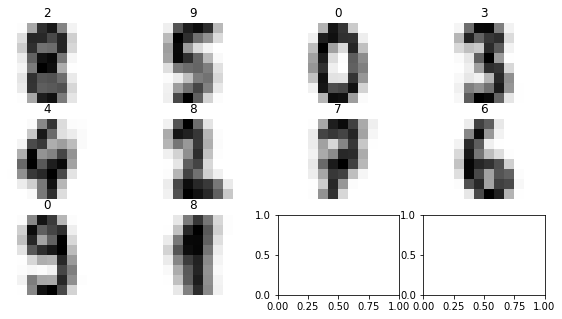

In [218]:
# KMeans
lb = labels['KMeans']
centers = cluster_centers(X, lb)
draw_dig(centers, lb)

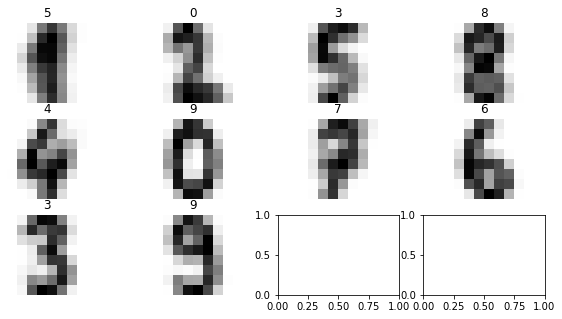

In [219]:
# AgglomerativeClustering
lb = labels['AgglomerativeClustering']
centers = cluster_centers(X, lb)
draw_dig(centers, lb)

**Выводы:** визуально центры кластеров стали лучше напоминать цифры.

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

**Выводы:**
Оба метода примерно одинаковы как визуально, так и на основании v_measure и silhouette (при K=10 v_measure выше для AgglomerativeClustering, silhouette для KMeans) - см. выаод ниже. Качество KMeans можно увелилчить, увеличивая параметр n_init.

KMeans k=10 v_measure=0.7433591627013836, silhouette=0.1824603259513644

AgglomerativeClustering k=10 v_measure=0.8681701126909083, silhouette=0.17849659940596496


Снижение размерности приводит у лучшению качества кластеризации (как визуально, так и на основании v_measure)


**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](https://stackoverflow.com/a/60450028). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [285]:
from sklearn.datasets import fetch_openml
Xdf, ydf= fetch_openml('mnist_784', version=1, return_X_y=True)

In [316]:
#Xdf.info

In [317]:
ydf = ydf.astype('int8')

In [318]:
ydf.groupby(by=ydf).count()

class
0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: class, dtype: int64

In [319]:
# import seaborn as sns
# sns.barplot(data=Xdf, edgecolor=(0,0,0), linewidth=2)


In [326]:
# Xdf_rs, ydf_rs = resample(Xdf, ydf, n_samples=1000, replace=False, stratify=y, random_state=10)
# Xdf_rs.info

# X = Xdf_rs.to_numpy()
# y = ydf_rs.to_numpy()
# X

In [327]:

X = Xdf.to_numpy()
y = ydf.to_numpy()

In [328]:
def draw_hand_dig(images, labels):
    _, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 5))
    for ax, image, label in zip(axes.flatten(), images, labels):
        ax.set_axis_off()
        ax.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r)
        ax.set_title(label)

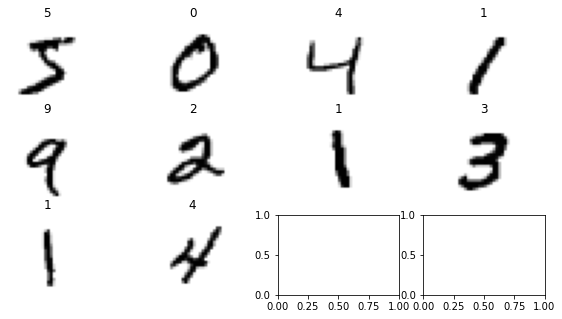

In [329]:
draw_hand_dig(X[:10], y[:10])

In [330]:
n_clusters = 10
n_components = 2
trunc = TSNE(n_components=n_components, random_state=42)      
X_trunc = trunc.fit_transform(X)

In [331]:
X_trunc

array([[ 23.506327 ,   0.7792196],
       [ 34.354362 ,  17.659786 ],
       [-42.035236 ,  18.248587 ],
       ...,
       [-46.208862 ,  -8.36696  ],
       [ 10.298166 ,   8.038193 ],
       [ 22.194477 ,  25.967646 ]], dtype=float32)

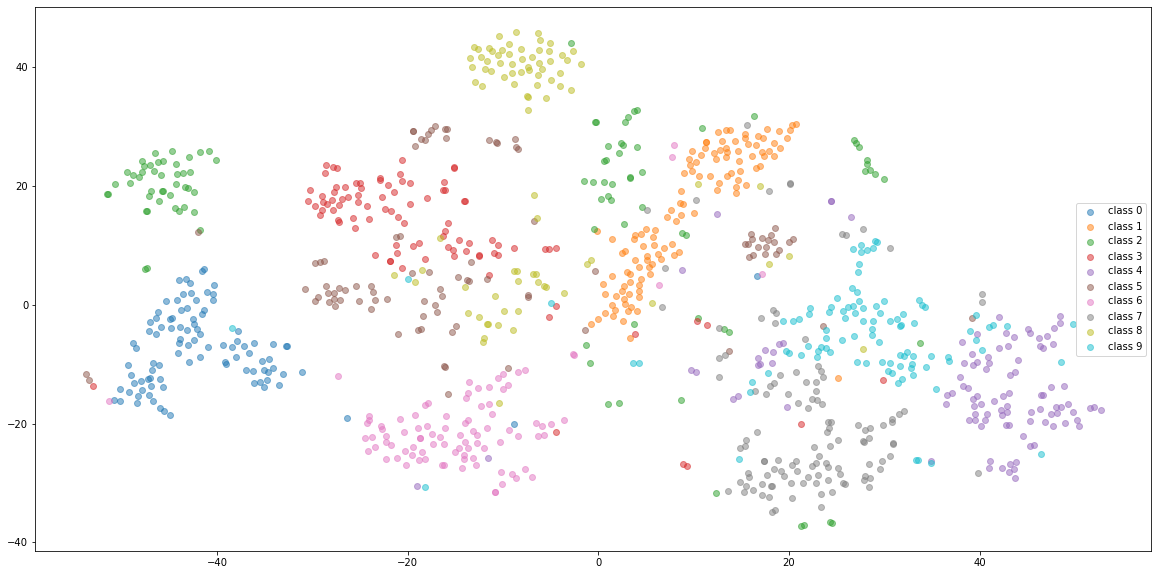

In [325]:
# plt.figure(figsize=(20, 10))
# for nc in range(0, n_clusters):
#     plt.scatter(X_trunc[y == nc, 0], X_trunc[y == nc, 1], 
#                 color=f'C{nc}', label=f'class {nc}', alpha=0.5)

# plt.legend(loc='center right')  
# plt.show()

In [332]:
n_clusters = 10 

n_clusters = 10 
k_model = ('KMeans', partial(KMeans, n_clusters=n_clusters, random_state=15, n_init=50))
a_model = ('AgglomerativeClustering', partial(AgglomerativeClustering, n_clusters=n_clusters))

labels = {}
for model_name, model_cls in (k_model, a_model):
    model = model_cls()
    model.fit(X_trunc)
    labels[model_name] = model.labels_
    silhouette = silhouette_score(X, model.labels_)
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, model.labels_)
    print(f'model_name={model_name} input_name={input_name} v_measure={v_measure} silhouette={silhouette}')
    

model_name=KMeans input_name=truncated v_measure=0.7465900511679366 silhouette=0.03302240623852288
model_name=AgglomerativeClustering input_name=truncated v_measure=0.8461086083621303 silhouette=0.04526096426953179


**Выводы:**
AgglomerativeClustering дает лучшие результаты (v_measure=0.8461086083621303 silhouette), но AgglomerativeClustering так же значительно более требовательный к ресурсам - время обучения (fit) гораздо больше чем у KMeans